In [1]:
from gerrychain import Graph
import geopandas as gpd
import networkx as nx
from networkx import is_connected, connected_components
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Set path of your dataframe in parquet format
DATAFRAME_PATH = 'ca_geodataframe.parquet'
# Set path of saved graph with connected islands
SAVE_PATH = 'ca_graph_islands_connected.json'

In [2]:
# Read in our final dataframe parquet to a geodataframe
gdf = gpd.read_parquet(DATAFRAME_PATH)

In [3]:
# Add centroid coordinates to the GeoDataFrame
gdf['centroid'] = gdf['geometry'].centroid

In [4]:
# Build graph from geodataframe, can take a while
graph = Graph.from_geodataframe(gdf)

/opt/anaconda3/envs/gerrychain/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/opt/anaconda3/envs/gerrychain/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [14]:
# Check if the graph is connected
# Must be connected to run gerrychain
# California has islands, so it is not connected
nx.is_connected(graph)

True

In [15]:
graph

<Graph [519723 nodes, 1292075 edges]>

In [7]:
# Check for connected/unconnected nodes
components = list(connected_components(graph))
[len(c) for c in components]

[519554, 81, 3, 7, 3, 25, 50]

In [8]:
# Connect islands/unconnected nodes instead of deleting them
biggest_component_size = max(len(c) for c in components)
mainland_component = [c for c in components if len(c) == biggest_component_size][0]
problem_components = [c for c in components if len(c) != biggest_component_size]

In [17]:
# Create a KDTree for efficient nearest neighbor search
mainland_nodes = np.array([gdf.loc[node, 'centroid'].coords[0] for node in mainland_component])
tree = cKDTree(mainland_nodes)

# Iterate through problem components and connect each island node to the nearest mainland node
island_mainland_edges = []
for component in problem_components:
    for island_node in component:
        island_node_coords = gdf.loc[island_node, 'centroid'].coords[0]
        dist, mainland_node_idx = tree.query(island_node_coords)
        mainland_node = list(mainland_component)[mainland_node_idx]
        graph.add_edge(island_node, mainland_node)
        island_mainland_edges.append((island_node, mainland_node))

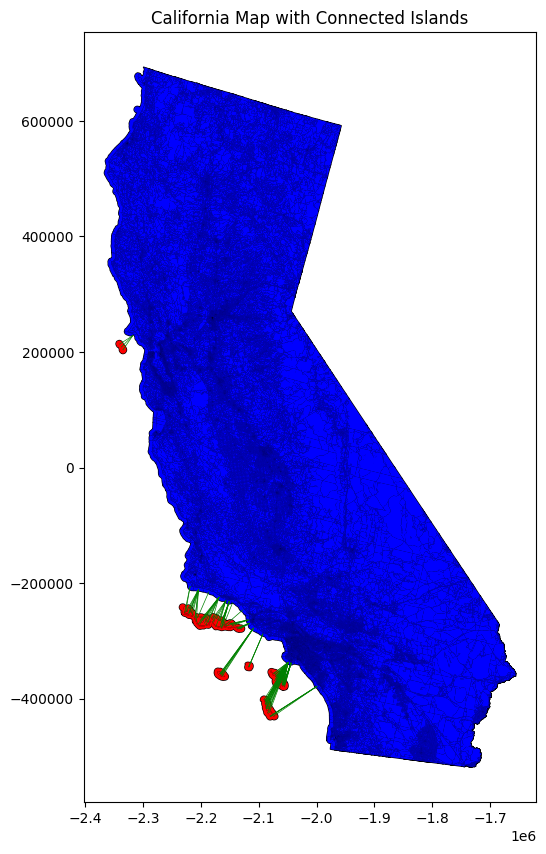

In [18]:
def plot_graph(graph, gdf, problem_components, mainland_component, island_mainland_edges):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the polygons
    gdf.plot(ax=ax, edgecolor='black', facecolor='none')

    # Plot the mainland nodes in blue
    mainland_gdf = gdf[gdf.index.isin(mainland_component)]
    mainland_gdf.plot(ax=ax, color='blue', markersize=5)

    # Plot the island nodes in red
    island_nodes = [node for component in problem_components for node in component]
    island_gdf = gdf[gdf.index.isin(island_nodes)]
    island_gdf.plot(ax=ax, color='red', markersize=5)

    # Draw the edges between island nodes and their connected mainland nodes in green
    for island_node, mainland_node in island_mainland_edges:
        island_coords = gdf.loc[island_node, 'centroid'].coords[0]
        mainland_coords = gdf.loc[mainland_node, 'centroid'].coords[0]
        ax.plot([island_coords[0], mainland_coords[0]], [island_coords[1], mainland_coords[1]], color='green', linewidth=0.5, zorder=3)

    ax.set_title('California Map with Connected Islands')
    plt.show()

# Call the function to plot the graph
plot_graph(graph, gdf, problem_components, mainland_component, island_mainland_edges)

In [ ]:
# Check graph with islands connected, should return true
nx.is_connected(graph)

In [19]:
# Save graph as json to run gerrychain later
graph.to_json(SAVE_PATH)